##### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CycleGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cyclegan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates unpaired image to image translation using conditional GAN's, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593), also known as CycleGAN. The paper proposes a method that can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples. 

This notebook assumes you are familiar with Pix2Pix, which you can learn about in the [Pix2Pix tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix). The code for CycleGAN is similar, the main difference is an additional loss function, and the use of unpaired training data.

CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain. 

This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer, etc. All you need is the source and the target dataset (which is simply a directory of images).

![Output Image 1](images/horse2zebra_1.png)
![Output Image 2](images/horse2zebra_2.png)

## Set up the input pipeline

Install the [tensorflow_examples](https://github.com/tensorflow/examples) package that enables importing of the generator and the discriminator.

In [3]:
# !pip install -q git+https://github.com/tensorflow/examples.git

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)

## Important: Sets up TF to not run out of GPU memory

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction=0.5
session = InteractiveSession(config=config)

## Input Pipeline

This tutorial trains a model to translate from images of horses, to images of zebras. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/datasets#cycle_gan). 

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [5]:
# dataset, metadata = tfds.load('cycle_gan/horse2zebra',
#                               with_info=True, as_supervised=True)

# train_horses, train_zebras = dataset['trainA'], dataset['trainB']
# test_horses, test_zebras = dataset['testA'], dataset['testB']

In [6]:
PATH = "./input/cycletrain/"


def load_pair(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [7]:
def load_single(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    return image

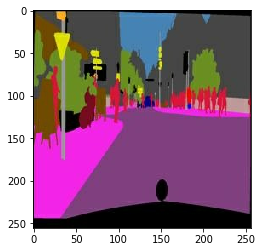

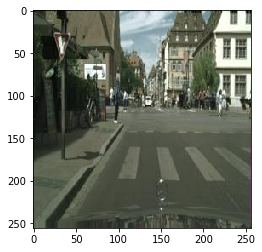

In [8]:
inp, re = load_pair(PATH+'train/2222.jpg')

# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [9]:
BUFFER_SIZE = 100
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [10]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [11]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [12]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [13]:
def preprocess_image_train(image, label=None):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [14]:
def preprocess_image_test(image, label=None):
  image = normalize(image)
  return image

In [15]:
def load_image_train(image_path):
    image = load_single(image_path)
    return preprocess_image_train(image)

In [16]:
def load_image_test(image_path):
    image = load_single(image_path)
    return preprocess_image_test(image)

In [17]:
def load_pair(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  
  input_image = tf.image.resize(input_image, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [IMG_HEIGHT, IMG_WIDTH],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def load_pair_train(image_file):
  input_image, real_image = load_pair(image_file)
  return preprocess_image_train(input_image), preprocess_image_train(real_image)

def load_pair_test(image_file):
  input_image, real_image = load_pair(image_file)
  return preprocess_image_test(input_image), preprocess_image_test(real_image)

In [18]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [19]:
def generate_image_pairs(model, test_input, tar, fname=None):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
    
  if fname:
    plt.savefig('./output/{}.png'.format(fname), bbox_inches='tight')
  
  plt.show()

## Acquiring Labelled Data

In [20]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_pair_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_pair_test)
test_dataset = test_dataset.batch(1)

## Unlabelled Data

In [21]:
train_real_paths = tf.data.Dataset.list_files(PATH+'train_real/*.jpg')
train_mask_paths = tf.data.Dataset.list_files(PATH+'train_mask/*.jpg')
test_real_paths = tf.data.Dataset.list_files(PATH+'test_real/*.jpg')
test_mask_paths = tf.data.Dataset.list_files(PATH+'test_mask/*.jpg')

train_reals= train_real_paths.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                          .cache() \
                          .shuffle(BUFFER_SIZE) \
                          .batch(BATCH_SIZE)

test_reals= test_real_paths.map(load_image_test,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                          .shuffle(BUFFER_SIZE) \
                          .batch(BATCH_SIZE)


train_masks = train_mask_paths.map(
    load_image_train, num_parallel_calls=AUTOTUNE)\
.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_masks = test_mask_paths.map(
    load_image_test, num_parallel_calls=AUTOTUNE)\
.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [22]:
sample_real = next(iter(train_reals))
sample_mask = next(iter(train_masks))

In [23]:
plt.subplot(121)
plt.title('Cityscape')
plt.imshow(sample_real[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Cityscape with random jitter')
plt.imshow(random_jitter(sample_real[0]) * 0.5 + 0.5)

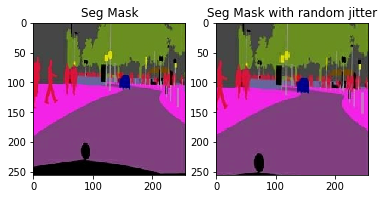

In [24]:
plt.subplot(121)
plt.title('Seg Mask')
plt.imshow(sample_mask[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Seg Mask with random jitter')
plt.imshow(random_jitter(sample_mask[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models

Import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

The model architecture used in this tutorial is very similar to what was used in [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Some of the differences are:

* Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).
* The [CycleGAN paper](https://arxiv.org/abs/1703.10593) uses a modified `resnet` based generator. This tutorial is using a modified `unet` generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here. 

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](images/cyclegan_model.png)

In [25]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# Using conditional discrminators
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=True)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=True)

In [26]:
discriminator_x.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, None, None, 6 0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_30 (Sequential)      (None, None, None, 6 6144        concatenate_2[0][0]        

In [27]:
discriminator_y.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, None, None, 6 0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_33 (Sequential)      (None, None, None, 6 6144        concatenate_3[0][0]        

## To train CycleGAN, we have to freeze the target layers to prevent weights frombeing updated
> ## Input will be tensor of zeroes

In [28]:
discriminator_x.layers

In [29]:
# target_layer_x = discriminator_x.get_layer("target_image")
# target_layer_y = discriminator_y.get_layer("target_image")

In [30]:
# discriminator_y.trainable_variables[0] 

In [31]:
# tf.Graph.get_collection(name="target_image")

In [32]:
# Prevent gradient from flowing into the conditional pair
# tf.stop_gradient(target_layer_x)
# tf.stop_gradient(target_layer_y)

In [33]:
to_zebra = generator_g(sample_mask)
to_horse = generator_f(sample_real)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_real, to_zebra, sample_mask, to_horse]
title = ['Real', 'To Mask', 'Mask', 'To Real']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


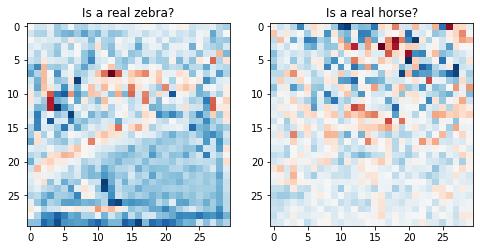

In [34]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y([sample_mask, to_zebra])[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x([sample_real, to_horse])[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer).

In [35]:
LAMBDA = 10

In [36]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [37]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [38]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](images/cycle_loss.png)

In [39]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [40]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [41]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Supervised Losses

In [42]:
SUP_LAMBDA = 100

def supervised_discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_obj(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_obj(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

def supervised_generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_obj(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (SUP_LAMBDA * l1_loss)

  return total_gen_loss

In [43]:
supervised_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
supervised_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# supervised_generator_optimizer = generator_g_optimizer
# supervised_discriminator_optimizer = discriminator_y_optimizer

## Checkpoints

In [62]:
checkpoint_path = "./checkpoints_cyclegan/unsup_train/"

unsupervised_ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

unsupervised_ckpt_manager = tf.train.CheckpointManager(unsupervised_ckpt, checkpoint_path, max_to_keep=None)

# if a checkpoint exists, restore the latest checkpoint.
ckpt_number = -1 # This should go in reverse (-ve)
if unsupervised_ckpt_manager.latest_checkpoint:
    print("Found:", unsupervised_ckpt_manager.checkpoints[ckpt_number])
    unsupervised_ckpt.restore(unsupervised_ckpt_manager.checkpoints[ckpt_number])
    print ('Checkpoint {} restored!'.format(len(unsupervised_ckpt_manager.checkpoints)+ckpt_number+1))

Found: ./checkpoints_cyclegan/unsup_train/ckpt-10
Checkpoint 10 restored!


In [63]:
checkpoint_dir = './checkpoints_cyclegan/super_train'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=supervised_generator_optimizer,
                                 discriminator_optimizer=supervised_discriminator_optimizer,
                                 generator=generator_g,
                                 discriminator=discriminator_y)

sup_ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=None)
# if a checkpoint exists, restore the latest checkpoint.
if sup_ckpt_manager.latest_checkpoint:
  checkpoint.restore(sup_ckpt_manager.latest_checkpoint)
  print ('Checkpoint {} restored!'.format(len(sup_ckpt_manager.checkpoints)+1))

In [64]:
# ckpt_save_path = ckpt_manager.save()
# checkpoint.save(file_prefix = checkpoint_prefix)

# print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

In [65]:
!ls {checkpoint_path}

checkpoint		     ckpt-5.data-00000-of-00002
ckpt-1.data-00000-of-00002   ckpt-5.data-00001-of-00002
ckpt-1.data-00001-of-00002   ckpt-5.index
ckpt-1.index		     ckpt-6.data-00000-of-00002
ckpt-10.data-00000-of-00002  ckpt-6.data-00001-of-00002
ckpt-10.data-00001-of-00002  ckpt-6.index
ckpt-10.index		     ckpt-7.data-00000-of-00002
ckpt-2.data-00000-of-00002   ckpt-7.data-00001-of-00002
ckpt-2.data-00001-of-00002   ckpt-7.index
ckpt-2.index		     ckpt-8.data-00000-of-00002
ckpt-3.data-00000-of-00002   ckpt-8.data-00001-of-00002
ckpt-3.data-00001-of-00002   ckpt-8.index
ckpt-3.index		     ckpt-9.data-00000-of-00002
ckpt-4.data-00000-of-00002   ckpt-9.data-00001-of-00002
ckpt-4.data-00001-of-00002   ckpt-9.index
ckpt-4.index


In [66]:
print(unsupervised_ckpt_manager.latest_checkpoint)

./checkpoints_cyclegan/unsup_train/ckpt-10


In [67]:
generate_images(generator_g, sample_mask)

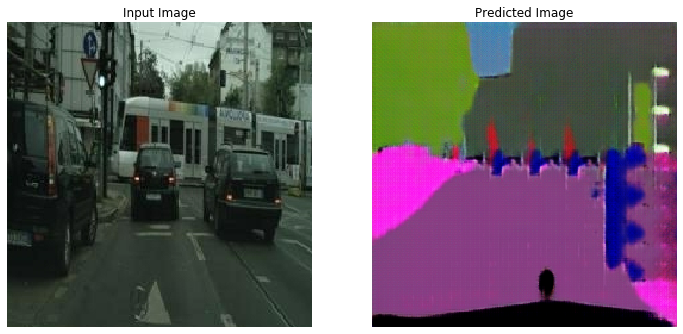

In [68]:
generate_images(generator_f, sample_real)


## Defining Training Steps

Note: This example model is trained for fewer epochs (40) than the paper (200) to keep training time reasonable for this tutorial. Predictions may be less accurate. 

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [51]:
@tf.function
def train_step(real_x, real_y):
    
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    
    # Prevent gradient from flowing into the conditional pair
#     tf.stop_gradient(target_layer_x)
#     tf.stop_gradient(target_layer_y)
    
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)
    
    
    # Condition with real images -> treat like (input,target) pairs
    # Hopefully they learn whole level info
    disc_real_x = discriminator_x([real_y, real_x], training=True)
    disc_real_y = discriminator_y([real_x, real_y], training=True)
    
    # Condition with the cyled image
    # OR with REAL source pair
    disc_fake_x = discriminator_x([real_y, fake_x], training=True)
    disc_fake_y = discriminator_y([real_x, fake_y], training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

## Training Generator G in a paired setting

In [52]:
@tf.function
def supervised_train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator_g(input_image, training=True)
    
    ## BUG: THE DISCRIMINATOR NEEDS TO BE CONDITIONED
    disc_real_output = discriminator_y([input_image, target], training=True)
    disc_generated_output = discriminator_y([input_image, gen_output], training=True)
    
    gen_loss = supervised_generator_loss(disc_generated_output, gen_output, target)
    disc_loss = supervised_discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator_g.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator_y.trainable_variables)

  supervised_generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator_g.trainable_variables))
  supervised_discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator_y.trainable_variables))
  return gen_loss, disc_loss

# ## OPTIONAL training step for Generator F
# @tf.function
# def aux_generator_train_step(input_image, target):
#   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#     gen_output = generator_f(input_image, training=True)

#     disc_real_output = discriminator_x([input_image, target], training=True)
#     disc_generated_output = discriminator_x([input_image, gen_output], training=True)
    
#     gen_loss = supervised_generator_loss(disc_generated_output, gen_output, target)
#     disc_loss = supervised_discriminator_loss(disc_real_output, disc_generated_output)

#   generator_gradients = gen_tape.gradient(gen_loss,
#                                           generator_g.trainable_variables)
#   discriminator_gradients = disc_tape.gradient(disc_loss,
#                                                discriminator_y.trainable_variables)

#   supervised_generator_optimizer.apply_gradients(zip(generator_gradients,
#                                           generator_g.trainable_variables))
#   supervised_discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
#                                               discriminator_y.trainable_variables))

## The last example pair will be used to illustrate training performance

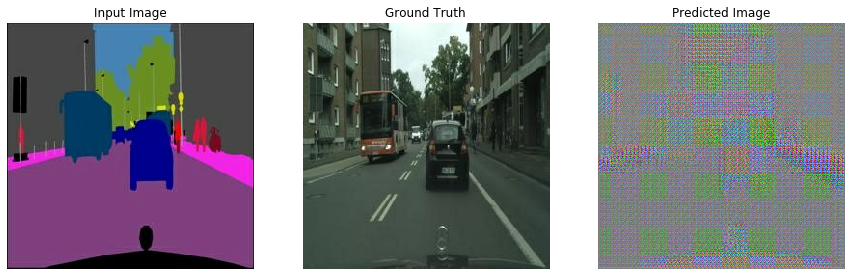

In [53]:
sample_pair = next(iter(test_dataset))
generate_image_pairs(generator_g, *sample_pair)

In [54]:
# print(" "*30 + "---------- Initial Performance ----------")
# # TODO: Add a subplot to combine all three images
# for example_input, example_target in test_dataset.take(2):
#     generate_image_pairs(generator_g, example_input, example_target)
# # plt.savefig("mode_collapse.png")

In [55]:
example_input, example_target = sample_pair

In [56]:
import datetime 

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

> ## Note that supervised training DOES use its own optimizer
> ## Using simplest conditioning

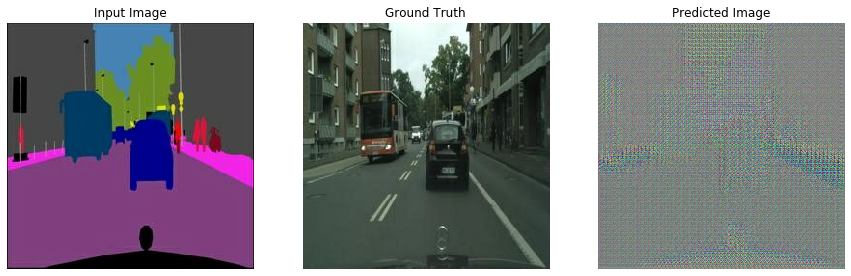

In [57]:
generate_image_pairs(generator_g, example_input, example_target, fname="condgan/g_epoch_{:04d}".format(999))

In [69]:
from tensorflow.keras.utils import Progbar

checkpoint.restore(sup_ckpt_manager.latest_checkpoint)
unsupervised_ckpt.restore(unsupervised_ckpt_manager.latest_checkpoint)

START_EPOCH = 10
EPOCHS = 40
SUPERVISED_EPOCHS = 20

In [ ]:
%%time

global_iter = 0
start = time.time()

for epoch in range(START_EPOCH, START_EPOCH+EPOCHS):
  start_ = time.time()
  unsup_progbar = Progbar(target=2000, width=100, unit_name="step")
  n = 0

  for image_x, image_y in tf.data.Dataset.zip((train_masks, train_reals)):
    train_step(image_x, image_y)
    
    if n % 10 == 0:
      unsup_progbar.update(n)
    n+=1

  # Using a consistent image so that the progress of the model
#   clear_output(wait=True)
  generate_image_pairs(generator_g, example_input, example_target, fname="condgan/g_epoch_{:04d}_u".format(epoch))
    
  if (epoch + 1) % 2 == 0:
    ckpt_save_path = unsupervised_ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for unsupervised epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start_))

print ('Total time for unsupoervised epochs {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

1990/2000 [==================================================================================================>.] - ETA: 4s

Time taken for unsupervised epoch 11 is 924.9603726863861 sec

 110/2000 [====>...............................................................................................] - ETA: 14:39

In [ ]:
%%time

start = time.time()

#Supervised Train
for epoch in range(SUPERVISED_EPOCHS):
    start_ = time.time()

    # Train
    sup_progbar = Progbar(target=975, width=100, unit_name="step")
    n_iter = 0
    for input_image, target in train_dataset:
      gLoss, dLoss = supervised_train_step(input_image, target)

      n_iter+=1
      global_iter += 1

      if n_iter % 25 == 0:
        sup_progbar.update(n_iter)

      with train_summary_writer.as_default():
        tf.summary.scalar('gen_loss', gLoss.numpy(), step=global_iter)
        tf.summary.scalar('disc_loss', dLoss.numpy(), step=global_iter)

    print ('Time taken for supervised epoch {} is {} sec\n'.format(epoch + 1, time.time()-start_))
    
    clear_output(wait=True)
    generate_image_pairs(generator_g, example_input, example_target, fname="condgan/g_epoch_{:04d}".format(epoch))
    # saving (checkpoint) the model
    if (epoch + 1) % 1 == 0:
      ckpt_save_path = sup_ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch_+1,
                                                       ckpt_save_path))

print ('Total time taken {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Generate using test dataset

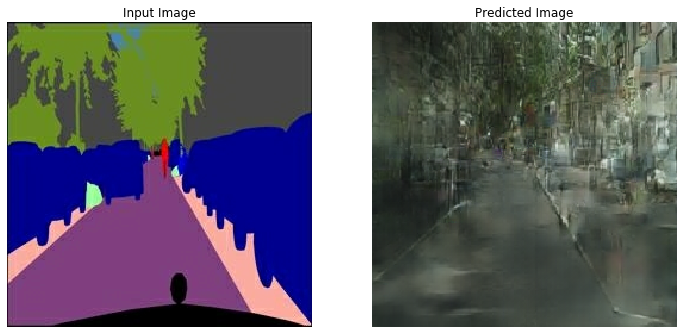

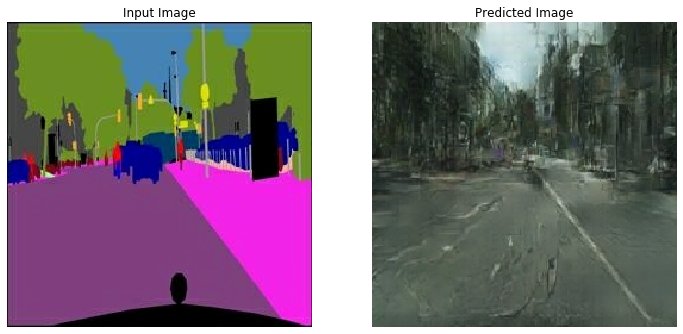

CPU times: user 904 ms, sys: 50.7 ms, total: 955 ms
Wall time: 894 ms


In [63]:
%%time
# Run the trained model on the test dataset
for inp in test_masks.take(3):
  generate_images(generator_g, inp)

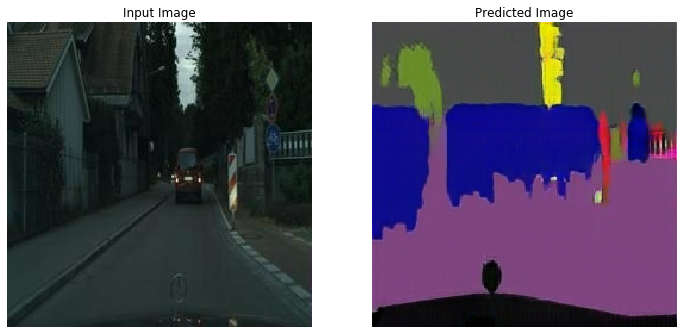

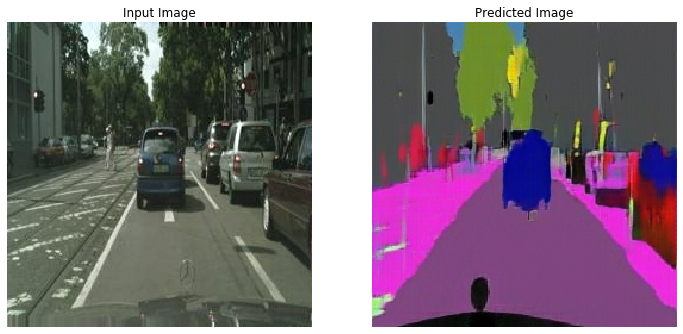

CPU times: user 932 ms, sys: 28.8 ms, total: 961 ms
Wall time: 848 ms


In [61]:
%%time
# Run the trained model on the test dataset
for inp in test_reals.take(3):
  generate_images(generator_f, inp)

In [69]:
## Reconstructing from checkpoints
sup_ckpt_manager.checkpoints

['./checkpoints_cyclegan/supervised_train/ckpt-1',
 './checkpoints_cyclegan/supervised_train/ckpt-2',
 './checkpoints_cyclegan/supervised_train/ckpt-3',
 './checkpoints_cyclegan/supervised_train/ckpt-4',
 './checkpoints_cyclegan/supervised_train/ckpt-5',
 './checkpoints_cyclegan/supervised_train/ckpt-6',
 './checkpoints_cyclegan/supervised_train/ckpt-7',
 './checkpoints_cyclegan/supervised_train/ckpt-8',
 './checkpoints_cyclegan/supervised_train/ckpt-9',
 './checkpoints_cyclegan/supervised_train/ckpt-10',
 './checkpoints_cyclegan/supervised_train/ckpt-11',
 './checkpoints_cyclegan/supervised_train/ckpt-12',
 './checkpoints_cyclegan/supervised_train/ckpt-13',
 './checkpoints_cyclegan/supervised_train/ckpt-14',
 './checkpoints_cyclegan/supervised_train/ckpt-15',
 './checkpoints_cyclegan/supervised_train/ckpt-16',
 './checkpoints_cyclegan/supervised_train/ckpt-17',
 './checkpoints_cyclegan/supervised_train/ckpt-18',
 './checkpoints_cyclegan/supervised_train/ckpt-19',
 './checkpoints_cycle

In [1]:
# for ckpt_num, ckpt_ in enumerate(sup_ckpt_manager.checkpoints):
#     print("Checkpoint:", ckpt_num)
#     checkpoint.restore(ckpt_)
#     generate_image_pairs(generator_g, example_input, example_target, fname="1by1/g_epoch_{:04d}".format(ckpt_num))
# #     plt.savefig('./output/1by1/epoch_{:04d}.png'.format(ckpt_num), bbox_inches='tight')

In [3]:
# for ckpt_num, ckpt_ in enumerate(unsupervised_ckpt_manager.checkpoints):
#     print("Checkpoint:", ckpt_num)
#     unsupervised_ckpt.restore(ckpt_)
#     generate_image_pairs(generator_f, example_target, example_input, fname="1by1/f_epoch_{:04d}".format(ckpt_num))
# #     plt.savefig('./output/1by1/epoch_{:04d}.png'.format(ckpt_num), bbox_inches='tight')